In [1]:
from river.datasets import  ImageSegments 
from river.preprocessing import MinMaxScaler 
from river.tree import HoeffdingTreeClassifier
from deep_river.classification import Classifier
from torch import nn 
from tqdm import tqdm 
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.manifold import TSNE
random.seed(0)

### Create Stream

In [2]:
stream_size = 10_000

x, y = list(zip(*ImageSegments()))
x = np.array(x)
y = np.array(y)

# Divide classes into two task specific sets
task_classes = [["brickface", "window", "cement"], ["sky", "foliage", "path", "grass"]]

# Divide all samples into their specific tasks
data_train = []
data_test = []
for classes_t in task_classes:
    x_t = np.concatenate([x[y == c] for c in classes_t])
    y_t = np.concatenate([330 * [c] for c in classes_t])
    x_train, x_test, y_train, y_test = train_test_split(
        x_t, y_t, test_size=0.25, stratify=y_t
    )
    x_train, y_train = resample(
        x_train, y_train, n_samples=int(stream_size / 2), stratify=y_train
    )
    data_train.append(list(zip(x_train, y_train)))
    data_test.append(list(zip(x_test, y_test)))

data_train = data_train[0] + data_train[1]

### Visualize Data

In [3]:
classnames = task_classes[0] + task_classes[1]
tsne = TSNE(init="pca", learning_rate="auto", n_jobs=-1)
x_array = np.array([list(x_i.values()) for x_i in x])
x_viz = tsne.fit_transform(x_array)

/Users/kulbach/Documents/environments/deep-river39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


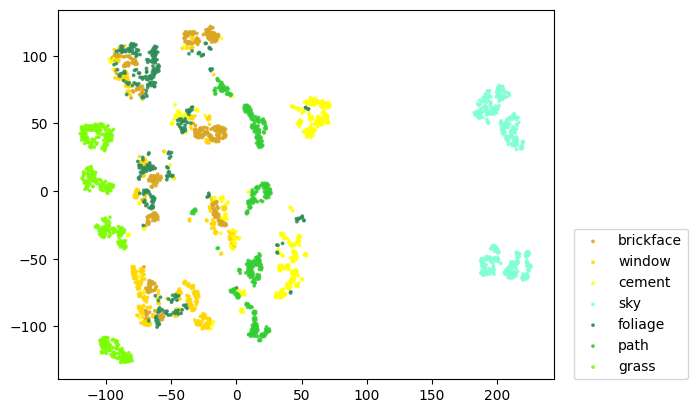

In [4]:
fig, ax = plt.subplots()
cm = ['goldenrod', 'gold', 'yellow', 'aquamarine', 'seagreen', 'limegreen', 'lawngreen']
for c_idx, x_c in enumerate([x_viz[y == c] for c in classnames]):
    scatter = ax.scatter(
        x_c[:, 0],
        x_c[:, 1],
        c=len(x_c) * [cm[c_idx]],
        s=3,
        alpha=0.8,
        label=classnames[c_idx],
    )

ax.legend(loc=(1.04, 0))


### Define evaluation procedure

In [5]:
# Define function to calculate accuracy on testing data for each task
def get_test_accuracy(model, data_test):
    results = []
    for data_test_i in data_test:
        ys = []
        y_preds = []
        for x_test, y_test in data_test_i:
            ys.append(y_test)
            y_preds.append(model.predict_one(x_test))
        accuracy = accuracy_score(ys, y_preds)
        results.append(accuracy)
    return results


# Define training and testing loop
def eval_separate_testing(model, data_train, data_test):
    scaler = MinMaxScaler()
    step = 0
    steps = []
    results = [[] for task in data_test]
    for x, y in tqdm(data_train):
        step += 1
        x = scaler.learn_one(x).transform_one(x)
        model.learn_one(x, y)

        if step % 100 == 0:
            test_accuracies = get_test_accuracy(model, data_test)
            for idx, accuracy in enumerate(test_accuracies):
                results[idx].append(accuracy)
            steps.append(step)
    return steps, results


## Evaluate Classifiers

In [6]:
# Evaluate a simple MLP classifier
class SimpleMLP(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.hidden1 = nn.Linear(n_features, 30)
        self.logits = nn.Linear(30, 7)

    def forward(self, x):
        h = torch.relu(self.hidden1(x))
        return self.logits(h)

mlp = Classifier(
    SimpleMLP,
    loss_fn="binary_cross_entropy_with_logits",
    optimizer_fn="sgd",
    lr=0.05,
    seed=42,
)
steps, results_mlp = eval_separate_testing(mlp, data_train, data_test)

100%|██████████| 10000/10000 [00:11<00:00, 888.76it/s]


In [7]:
# Evaluate a Hoeffding Tree classifier
tree = HoeffdingTreeClassifier(tau=0.05)
steps, results_tree = eval_separate_testing(tree, data_train, data_test)

100%|██████████| 10000/10000 [00:15<00:00, 646.91it/s]


### Visualize Accuracy over Timesteps

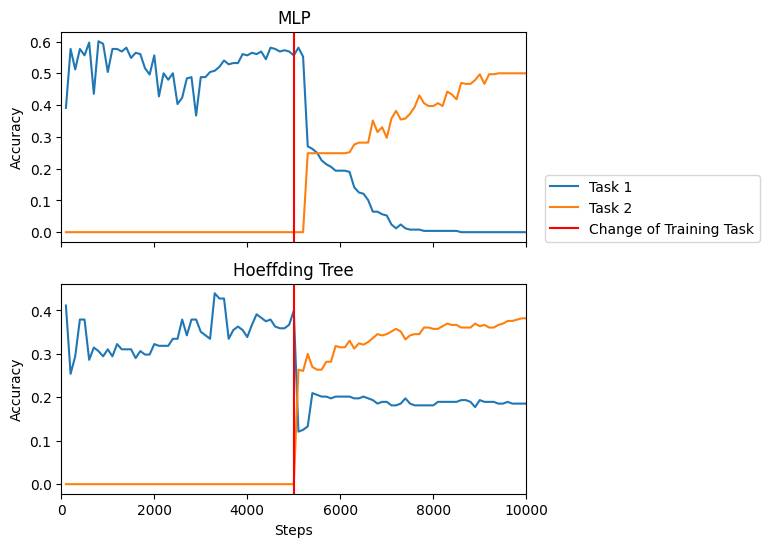

In [8]:
fig, axs = plt.subplots(nrows=2, figsize=(6, 6), sharex=True)
results = {"MLP": results_mlp, "Hoeffding Tree": results_tree}
for model_idx, (model_name, model_results) in enumerate(results.items()):
    ax = axs[model_idx]
    ax.plot(steps, model_results[0], label="Task 1")
    ax.plot(steps, model_results[1], label="Task 2")
    ax.axvline(5000, c="red", label="Change of Training Task")
    ax.set_ylabel("Accuracy")
    ax.set_title(model_name)
axs[-1].set_xlabel("Steps")
axs[-1].set_xlim(0, 10000)
axs[0].legend(loc=(1.04, 0))